# Feature Engineering: Journey Bike Data

In [170]:
import pandas as pd
import numpy as np
import holidays
from datetime import datetime
import seaborn as sns

# import python modules
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/tabea/Documents/UrbanMobility/src')
from features import journey_data_feature_engineering as features
from data import journey_data_preprocessing as preprocess
from visualization import station_locations_vis as vis_stations

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
# import data
bike_locs = pd.read_csv('../data/interim/station_locations_boroughs.csv')
journey_df = pd.read_csv('../data/interim/journey_data_cleaned.csv', parse_dates=['end_date', 'start_date'], index_col=0)

/Users/tabea/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# 1. TEMPORAL FEATURE ENGINEERING

Features: 
- hour (1-24)
- part_of_day (early morning: 1, morning: 2, afternoon: 3, evening: 4, night: 5)
- day_of_week (1-7)
- is_weekend (boolean)
- month (1-12)
- season (1-4)
- bank_holiday (boolean)
- year

In [15]:
uk_holidays = holidays.UK()

journey_df['day_of_week'] = journey_df['start_date'].dt.dayofweek
journey_df['hour'] = journey_df['start_date'].dt.hour
journey_df['is_weekend'] = journey_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0) 
journey_df['part_of_day'] = journey_df['hour'].apply(features.get_part_of_day)
journey_df['month'] = journey_df['start_date'].dt.month
journey_df['season'] = journey_df['month'].apply(features.get_season)
journey_df['bank_holiday'] = journey_df['start_date'].apply(lambda x: 1 if x in uk_holidays else 0)
journey_df['year'] = journey_df['start_date'].dt.year

In [16]:
journey_df.head()

,rental_id,end_date,end_station_name,start_date,start_station_name,day_of_week,hour,is_weekend,part_of_day,month,season,bank_holiday
16646400,50608184.0,2016-01-01 01:14:00,"Hampstead Road (Cartmel), Euston",2016-01-01 00:00:00,"Hampstead Road, Euston",4,0,0,5,1,4,1
16646401,50608186.0,2016-01-01 00:24:00,"Rochester Row, Westminster",2016-01-01 00:04:00,"Chelsea Bridge, Pimlico",4,0,0,5,1,4,1
16646402,50608187.0,2016-01-01 00:24:00,"Rochester Row, Westminster",2016-01-01 00:04:00,"Chelsea Bridge, Pimlico",4,0,0,5,1,4,1
16646403,50608188.0,2016-01-01 00:22:00,"Brushfield Street, Liverpool Street",2016-01-01 00:04:00,"Holborn Circus, Holborn",4,0,0,5,1,4,1
16646405,50608189.0,2016-01-01 00:23:00,"Brushfield Street, Liverpool Street",2016-01-01 00:05:00,"Holborn Circus, Holborn",4,0,0,5,1,4,1


# 2. WEATHER FEATURE ENGINEERING

The daily weather data are generated with the weather data builder by www.visualcrossing.com

Features:
- tempmax
- tempmin
- temp
- feelslike
- humidity
- precip
- windgust
- windspeed
- cloudcover
- visibility
- uvindex
- daylight_hours

### 2.1 Load and Enhance Weather Data

In [17]:
# load data
weather_df = pd.read_csv('../data/external/weather_london_2016-2022.csv', index_col=0, encoding='ISO-8859-1')
weather_df.index = pd.to_datetime(weather_df.index).date
weather_df.head()

,tempmax,tempmin,temp,feelslike,humidity,precip,windgust,windspeed,cloudcover,visibility,uvindex,sunrise,sunset
datetime,,,,,,,,,,,,,
2016-01-01,8.6,2.6,5.9,5.9,84.7,3.800,50.0,0.2,61.3,18.6,1,2016-01-01T08:06:16,2016-01-01T16:01:33
2016-01-02,10.8,8.1,10.0,10.0,89.7,1.257,46.4,0.2,90.7,14.5,1,2016-01-02T08:06:10,2016-01-02T16:02:36
2016-01-03,10.3,6.3,8.0,8.0,87.7,10.214,53.6,0.2,60.0,20.5,0,2016-01-03T08:06:01,2016-01-03T16:03:42
2016-01-04,10.8,6.0,8.0,8.0,87.9,0.201,NaN,0.1,45.7,20.1,1,2016-01-04T08:05:49,2016-01-04T16:04:51
2016-01-05,10.6,6.8,8.4,8.4,89.5,0.218,NaN,5.2,65.1,17.0,1,2016-01-05T08:05:33,2016-01-05T16:06:02


In [20]:
# clean and enhance weather data: add daylight_hours and replace NaN by 0

weather_df = features.clean_enhance_weather_data(weather_df)
weather_df.head()

,tempmax,tempmin,temp,feelslike,humidity,precip,windgust,windspeed,cloudcover,visibility,uvindex,daylight_hours
datetime,,,,,,,,,,,,
2016-01-01,8.6,2.6,5.9,5.9,84.7,3.800,50.0,0.2,61.3,18.6,1,7.921389
2016-01-02,10.8,8.1,10.0,10.0,89.7,1.257,46.4,0.2,90.7,14.5,1,7.940556
2016-01-03,10.3,6.3,8.0,8.0,87.7,10.214,53.6,0.2,60.0,20.5,0,7.961389
2016-01-04,10.8,6.0,8.0,8.0,87.9,0.201,0.0,0.1,45.7,20.1,1,7.983889
2016-01-05,10.6,6.8,8.4,8.4,89.5,0.218,0.0,5.2,65.1,17.0,1,8.008056


### 2.2 Map Weather Data to Journey Data

In [23]:
journey_df = features.merge_weather_journey_data(journey_df, weather_df)

In [24]:
print(journey_df.isna().sum())
journey_df.head()

rental_id             0
end_date              0
end_station_name      0
start_date            0
start_station_name    0
day_of_week           0
hour                  0
is_weekend            0
part_of_day           0
month                 0
season                0
bank_holiday          0
tempmax               0
tempmin               0
temp                  0
feelslike             0
humidity              0
precip                0
windgust              0
windspeed             0
cloudcover            0
visibility            0
uvindex               0
daylight_hours        0
dtype: int64


,rental_id,end_date,end_station_name,start_date,start_station_name,day_of_week,hour,is_weekend,part_of_day,month,...,temp,feelslike,humidity,precip,windgust,windspeed,cloudcover,visibility,uvindex,daylight_hours
16646400,50608184.0,2016-01-01 01:14:00,"Hampstead Road (Cartmel), Euston",2016-01-01 00:00:00,"Hampstead Road, Euston",4,0,0,5,1,...,5.9,5.9,84.7,3.8,50.0,0.2,61.3,18.6,1,7.921389
16646401,50608186.0,2016-01-01 00:24:00,"Rochester Row, Westminster",2016-01-01 00:04:00,"Chelsea Bridge, Pimlico",4,0,0,5,1,...,5.9,5.9,84.7,3.8,50.0,0.2,61.3,18.6,1,7.921389
16646402,50608187.0,2016-01-01 00:24:00,"Rochester Row, Westminster",2016-01-01 00:04:00,"Chelsea Bridge, Pimlico",4,0,0,5,1,...,5.9,5.9,84.7,3.8,50.0,0.2,61.3,18.6,1,7.921389
16646403,50608188.0,2016-01-01 00:22:00,"Brushfield Street, Liverpool Street",2016-01-01 00:04:00,"Holborn Circus, Holborn",4,0,0,5,1,...,5.9,5.9,84.7,3.8,50.0,0.2,61.3,18.6,1,7.921389
16646405,50608189.0,2016-01-01 00:23:00,"Brushfield Street, Liverpool Street",2016-01-01 00:05:00,"Holborn Circus, Holborn",4,0,0,5,1,...,5.9,5.9,84.7,3.8,50.0,0.2,61.3,18.6,1,7.921389


# 3. MAPPING BOROUGHS TO JOURNEY DATA 

### 3.1 Direct Mapping by Station Name

In [25]:
journey_df = features.direct_borough_mapping_by_stationname(bike_locs, journey_df)

# still lots of missing boroughs: 2'314'797 + 2'337'714
print(journey_df.isna().sum())

rental_id                   0
end_date                    0
end_station_name            0
start_date                  0
start_station_name          0
day_of_week                 0
hour                        0
is_weekend                  0
part_of_day                 0
month                       0
season                      0
bank_holiday                0
tempmax                     0
tempmin                     0
temp                        0
feelslike                   0
humidity                    0
precip                      0
windgust                    0
windspeed                   0
cloudcover                  0
visibility                  0
uvindex                     0
daylight_hours              0
start_borough         2314797
end_borough           2337714
dtype: int64


### 3.2 Fuzzy Matching for empty Boroughs
Matching names that refer to the same station but are slightly different in their naming. Parallel processing to improve the performance of fuzzy matching.

In [28]:
journey_df = features.fuzzy_borough_mapping_by_stationname(bike_locs, journey_df)

# reduced number of missing values to 1'744'880 + 1'789'528
print(journey_df.isna().sum())

rental_id                   0
end_date                    0
end_station_name            0
start_date                  0
start_station_name          0
day_of_week                 0
hour                        0
is_weekend                  0
part_of_day                 0
month                       0
season                      0
bank_holiday                0
tempmax                     0
tempmin                     0
temp                        0
feelslike                   0
humidity                    0
precip                      0
windgust                    0
windspeed                   0
cloudcover                  0
visibility                  0
uvindex                     0
daylight_hours              0
start_borough         1744880
end_borough           1789528
dtype: int64


### 3.3 Region Mapping for Former Station

After investigating the missing borough data in the current samplers, it was discovered that these samplers correspond to former stations that are no longer in use and are not listed in the provided BikePoints file, where the station names are given in the format "street name, region" (e.g., "London Fields, Hackney Central").

To address this a dictionary with the region information as key and the borough with the maximum counts as value is created. This is then used to map the missing boroughs in the merged_df DataFrame based on the extracted location information.

In [40]:
journey_df = features.former_station_borough_mapping_by_region(bike_locs, journey_df)

# still some missing values: 8855 + 9287
print(journey_df.isna().sum())

rental_id                0
end_date                 0
end_station_name         0
start_date               0
start_station_name       0
day_of_week              0
hour                     0
is_weekend               0
part_of_day              0
month                    0
season                   0
bank_holiday             0
tempmax                  0
tempmin                  0
temp                     0
feelslike                0
humidity                 0
precip                   0
windgust                 0
windspeed                0
cloudcover               0
visibility               0
uvindex                  0
daylight_hours           0
start_borough         8855
end_borough           9287
dtype: int64


### 3.4 Manual Mapping and Drop Irrelevant Stations

About 10 stations were still not mapped to boroughs, so they were manually assigned. Stations labeled as 'Test' or 'Workshop' were dropped. Now, all entries are associated with a borough.

In [44]:
unique_empty_start_boroughs = journey_df.loc[journey_df['start_borough'].isna(), 'start_station_name'].unique()
unique_empty_end_boroughs = journey_df.loc[journey_df['end_borough'].isna(), 'end_station_name'].unique()
unique_empty_boroughs = np.union1d(unique_empty_start_boroughs, unique_empty_end_boroughs)


for name in unique_empty_boroughs:
    print(name)

Allington street, Off Victoria Street, Westminster
Canada Water Station
Contact Centre, Southbury House
Imperial Wharf Station
Import Dock
LSP1
LSP2
Mechanical Workshop Clapham
Mechanical Workshop Penton
Monier Road, Newham
One London
PENTON STREET COMMS TEST TERMINAL _ CONTACT MATT McNULTY
Pop Up Dock 1
Pop Up Dock 2
Victoria and Albert Museum, Cromwell Road
Worship Street, Hackney
York Way, Camden


In [46]:
journey_df = features.manual_borough_mapping(journey_df)

# no missing boroughs.. hurray!
print(journey_df.isna().sum())

rental_id             0
end_date              0
end_station_name      0
start_date            0
start_station_name    0
day_of_week           0
hour                  0
is_weekend            0
part_of_day           0
month                 0
season                0
bank_holiday          0
tempmax               0
tempmin               0
temp                  0
feelslike             0
humidity              0
precip                0
windgust              0
windspeed             0
cloudcover            0
visibility            0
uvindex               0
daylight_hours        0
start_borough         0
end_borough           0
dtype: int64


rental_id             0
end_date              0
end_station_name      0
start_date            0
start_station_name    0
start_borough         0
end_borough           0
dtype: int64


### 3.5 Save Interim Data

In [47]:
journey_df.to_csv('../data/interim/journey_data_cleaned_featureeng_1_2_3.csv')

# 4. BOROUGH DEMOGRAPHIC FEATURE ENGINEERING

Data Source
- TSXXX: Census 2021, the census is undertaken by the Office for National Statistics every 10 years and gives us a picture of all the people and households in England and Wales.
- ADDXXX: Additional data

In [105]:
# import journey data
journey_df = pd.read_csv('../data/interim/journey_data_cleaned_featureeng_1_2_3.csv', parse_dates=['end_date', 'start_date'], index_col=0)

# import journey_data -> focus on 2019
start_date = datetime(2019, 1, 1) 
end_date = datetime(2019, 12, 31)
journey_19_df = preprocess.filter_date(journey_df, start_date, end_date)
journey_19_df.to_csv('../data/interim/journey_data_2019_cleaned_featureeng_1_2_3.csv')

In [315]:
# import borough data, add bike station counts
bike_locs = pd.read_csv('../data/interim/station_locations_boroughs.csv')
borough_df = vis_stations.count_stations_per_borough(bike_locs)


borough_df = borough_df.reset_index()
borough_df.columns = ['borough', 'bike_station_counts']
borough_df.head()


,borough,bike_station_counts
0,Westminster,171
1,Tower Hamlets,116
2,Kensington and Chelsea,94
3,Camden,64
4,Lambeth,59


In [316]:
# add yearly demand and demand standardised by bike station counts
borough_df = borough_df.set_index('borough')

demand_start = journey_19_df.groupby('start_borough')['start_station_name'].count()
demand_end = journey_19_df.groupby('end_borough')['start_station_name'].count()

borough_df['demand_count_2019_start_borough'] = demand_start
borough_df['demand_count_2019_end_borough'] = demand_end

borough_df['demand_stand_count_2019_start_borough'] = borough_df['demand_count_2019_start_borough'] / borough_df['bike_station_counts']
borough_df['demand_stand_count_2019_end_borough'] = borough_df['demand_count_2019_end_borough'] / borough_df['bike_station_counts']

borough_df.head(13)


,bike_station_counts,demand_count_2019_start_borough,demand_count_2019_end_borough,demand_stand_count_2019_start_borough,demand_stand_count_2019_end_borough
borough,,,,,
Westminster,171,2507361,2568590,14662.929825,15020.994152
Tower Hamlets,116,1218646,1182429,10505.568966,10193.353448
Kensington and Chelsea,94,1111799,1093913,11827.648936,11637.372340
Camden,64,963135,960684,15048.984375,15010.687500
Lambeth,59,811940,798973,13761.694915,13541.915254
Wandsworth,59,521974,510976,8847.016949,8660.610169
Hammersmith and Fulham,57,606508,599670,10640.491228,10520.526316
Southwark,56,669853,695929,11961.660714,12427.303571
Hackney,39,495632,463453,12708.512821,11883.410256


In [317]:
# TS006 population density: population_density and borough_code
TS006_df = pd.read_csv('../data/external/TS006_population_density.csv')
TS006_df = TS006_df.rename(columns={"Population Density: Persons per square kilometre; measures: Value": "population_density", 'geography code': 'borough_code', 'geography': 'borough'})
borough_df = borough_df.merge(TS006_df[["population_density", "borough_code", "borough"]], on='borough', how='left')
borough_df.head()

,borough,bike_station_counts,demand_count_2019_start_borough,demand_count_2019_end_borough,demand_stand_count_2019_start_borough,demand_stand_count_2019_end_borough,population_density,borough_code
0,Westminster,171,2507361,2568590,14662.929825,15020.994152,9514.2,E09000033
1,Tower Hamlets,116,1218646,1182429,10505.568966,10193.353448,15702.9,E09000030
2,Kensington and Chelsea,94,1111799,1093913,11827.648936,11637.372340,11816.5,E09000020
3,Camden,64,963135,960684,15048.984375,15010.687500,9640.9,E09000007
4,Lambeth,59,811940,798973,13761.694915,13541.915254,11839.1,E09000022


In [318]:
# TS007 age: age_mean, age_percentile_25, age_percentile_75
TS007_df = pd.read_csv('../data/external/TS007_age.csv')

def compute_age_stats(df):
    # Replicate each age value according to its frequency
    ages = np.repeat(df['age'], df['frequency'])

    # Calculate statistics
    age_mean = np.mean(ages)
    age_25_percentile = np.percentile(ages, 25)
    age_75_percentile = np.percentile(ages, 75)

    return pd.Series({'age_mean': age_mean, 
                      'age_25_percentile': age_25_percentile, 
                      'age_75_percentile': age_75_percentile})


# Convert columns to integers
age_cols = TS007_df.columns[2:].astype(int)
TS007_df.columns = list(TS007_df.columns[:2]) + list(age_cols)

# Melt the dataframe to have ages in one column and their frequencies in another
melted_df = TS007_df.melt(id_vars=['borough_code', 'age_total'], var_name='age', value_name='frequency')
melted_df['age'] = melted_df['age'].astype(int)

# Group by borough and apply function
age_stats = melted_df.groupby('borough_code').apply(compute_age_stats)


# Merge with borough_df
borough_df = borough_df.merge(age_stats, left_on='borough_code', right_index=True, how='left')


borough_df.head()



,borough,bike_station_counts,demand_count_2019_start_borough,demand_count_2019_end_borough,demand_stand_count_2019_start_borough,demand_stand_count_2019_end_borough,population_density,borough_code,age_mean,age_25_percentile,age_75_percentile
0,Westminster,171,2507361,2568590,14662.929825,15020.994152,9514.2,E09000033,38.280112,24.0,53.0
1,Tower Hamlets,116,1218646,1182429,10505.568966,10193.353448,15702.9,E09000030,31.984699,21.0,42.0
2,Kensington and Chelsea,94,1111799,1093913,11827.648936,11637.372340,11816.5,E09000020,39.951470,24.0,56.0
3,Camden,64,963135,960684,15048.984375,15010.687500,9640.9,E09000007,37.006034,22.0,52.0
4,Lambeth,59,811940,798973,13761.694915,13541.915254,11839.1,E09000022,35.826829,24.0,49.0


In [319]:
# TS008 sex: female_ratioLoad your gender data into a dataframe
TS008_df = pd.read_csv('../data/external/TS008_gender.csv')
TS008_df['female_ratio'] = TS008_df['female'] / TS008_df['all']
borough_df = borough_df.merge(TS008_df[['borough_code', 'female_ratio']], on='borough_code', how='left')
borough_df.head(13)


,borough,bike_station_counts,demand_count_2019_start_borough,demand_count_2019_end_borough,demand_stand_count_2019_start_borough,demand_stand_count_2019_end_borough,population_density,borough_code,age_mean,age_25_percentile,age_75_percentile,female_ratio
0,Westminster,171,2507361,2568590,14662.929825,15020.994152,9514.2,E09000033,38.280112,24.0,53.0,0.515712
1,Tower Hamlets,116,1218646,1182429,10505.568966,10193.353448,15702.9,E09000030,31.984699,21.0,42.0,0.497693
2,Kensington and Chelsea,94,1111799,1093913,11827.648936,11637.372340,11816.5,E09000020,39.951470,24.0,56.0,0.532255
3,Camden,64,963135,960684,15048.984375,15010.687500,9640.9,E09000007,37.006034,22.0,52.0,0.526573
4,Lambeth,59,811940,798973,13761.694915,13541.915254,11839.1,E09000022,35.826829,24.0,49.0,0.515382
5,Wandsworth,59,521974,510976,8847.016949,8660.610169,9560.0,E09000032,35.724045,24.0,49.0,0.525954
6,Hammersmith and Fulham,57,606508,599670,10640.491228,10520.526316,11161.1,E09000013,36.504294,23.0,51.0,0.530769
7,Southwark,56,669853,695929,11961.660714,12427.303571,10659.0,E09000028,35.435768,22.0,49.0,0.515650
8,Hackney,39,495632,463453,12708.512821,11883.410256,13593.3,E09000012,34.288071,21.0,47.0,0.522111
9,City of London,38,772788,838528,20336.526316,22066.526316,2975.0,E09000001,40.704977,26.0,55.0,0.449843


In [322]:
# TS017 household size: household_size_1_ratio, household_size_2_ratio, household_size_3-5_ratio, household_size_6+_ratio

TS017_df = pd.read_csv('../data/external/TS017_household_size.csv')

# Calculate ratio for each household size
for size in range(1, 9):
    original_column = f'householdsize_{size}'
    new_column = original_column + '_ratio'
    TS017_df[new_column] = TS017_df[original_column] / TS017_df['all']

# Drop unnecessary columns
columns_to_drop = ['all'] + [f'householdsize_{i}' for i in range(1, 9)]
TS017_df = TS017_df.drop(columns=columns_to_drop)

# Merge with borough_df
borough_df = borough_df.merge(TS017_df, on='borough_code', how='left')

borough_df.head()



,borough,bike_station_counts,demand_count_2019_start_borough,demand_count_2019_end_borough,demand_stand_count_2019_start_borough,demand_stand_count_2019_end_borough,population_density,borough_code,age_mean,age_25_percentile,age_75_percentile,female_ratio,householdsize_1_ratio,householdsize_2_ratio,householdsize_3_ratio,householdsize_4_ratio,householdsize_5_ratio,householdsize_6_ratio,householdsize_7_ratio,householdsize_8_ratio
0,Westminster,171,2507361,2568590,14662.929825,15020.994152,9514.2,E09000033,38.280112,24.0,53.0,0.515712,0.426546,0.301693,0.127290,0.079977,0.038180,0.015346,0.005179,0.005790
1,Tower Hamlets,116,1218646,1182429,10505.568966,10193.353448,15702.9,E09000030,31.984699,21.0,42.0,0.497693,0.319656,0.310580,0.142933,0.103817,0.061739,0.033483,0.014493,0.013299
2,Kensington and Chelsea,94,1111799,1093913,11827.648936,11637.372340,11816.5,E09000020,39.951470,24.0,56.0,0.532255,0.437055,0.289127,0.123303,0.083383,0.039157,0.015205,0.007849,0.004919
3,Camden,64,963135,960684,15048.984375,15010.687500,9640.9,E09000007,37.006034,22.0,52.0,0.526573,0.387345,0.309217,0.139925,0.098774,0.040396,0.014921,0.005563,0.003860
4,Lambeth,59,811940,798973,13761.694915,13541.915254,11839.1,E09000022,35.826829,24.0,49.0,0.515382,0.320404,0.332989,0.166825,0.111303,0.040665,0.016067,0.006118,0.005628


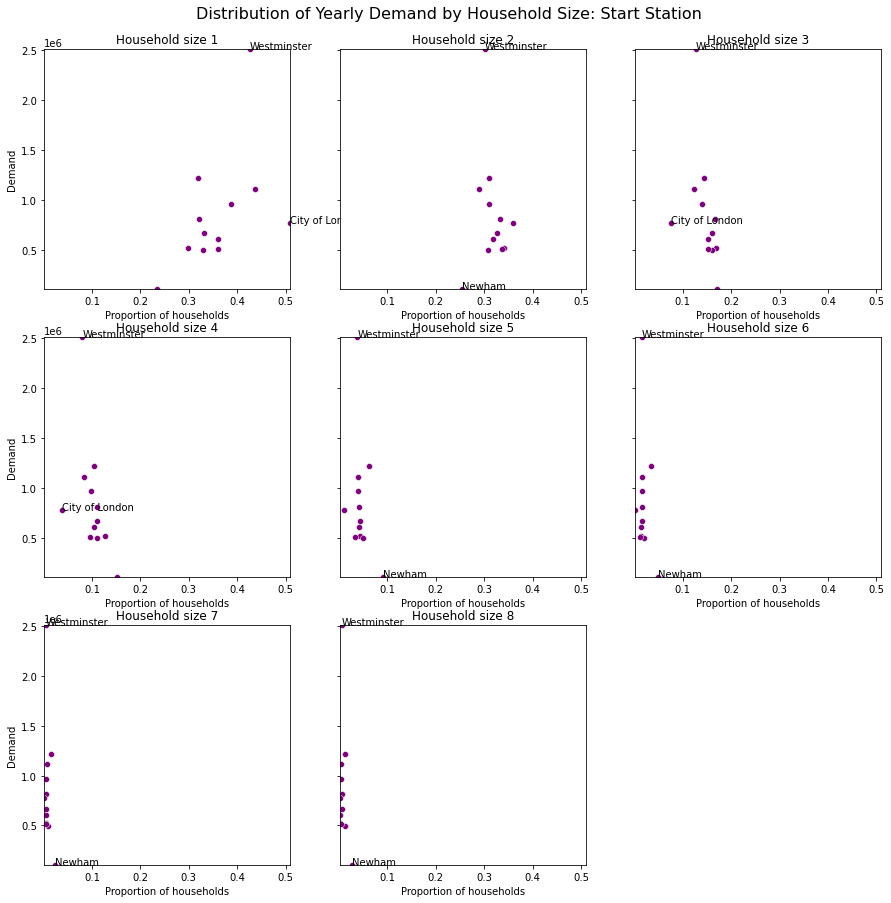

In [349]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Define a function to find outliers
def find_outliers(df, column1, column2):
    df = df.copy()  # Make a copy to avoid modifying original df
    df['Z_score1'] = zscore(df[column1])
    df['Z_score2'] = zscore(df[column2])
    outliers_df = df[(abs(df['Z_score1']) > 2) | (abs(df['Z_score2']) > 2)]
    return outliers_df

# Define max and min values for x and y axis
x_min = borough_df[[f'householdsize_{i}_ratio' for i in range(1, 9)]].min().min()
x_max = borough_df[[f'householdsize_{i}_ratio' for i in range(1, 9)]].max().max()
y_min = borough_df['demand_count_2019_start_borough'].min()
y_max = borough_df['demand_count_2019_start_borough'].max()

# Setup a grid of plots with 3 columns
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharey=True)

# Remove the last plot (we have 8 plots for household size 1-8, so the 9th plot is unnecessary)
fig.delaxes(axs[2,2])

# Iterate over each subplot
for i, ax in enumerate(fig.axes):
    if i < 8:
        col = f'householdsize_{i+1}_ratio'
        
        outliers_df = find_outliers(borough_df, col, 'demand_count_2019_start_borough')
    
        sns.scatterplot(x=col, y='demand_count_2019_start_borough', data=borough_df, ax=ax, color='purple') 
        
        for k in outliers_df.index:
            ax.annotate(outliers_df.loc[k, 'borough'], (outliers_df.loc[k, col], outliers_df.loc[k, 'demand_count_2019_start_borough']))

        # Set title and labels
        ax.set_title(f'Household size {i+1}')
        ax.set_xlabel('Proportion of households')
        ax.set_ylabel('Demand')

        # Set x and y limits
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])

# Set main title
plt.suptitle('Distribution of Yearly Demand by Household Size: Start Station', fontsize=16, y=0.92)

plt.show()


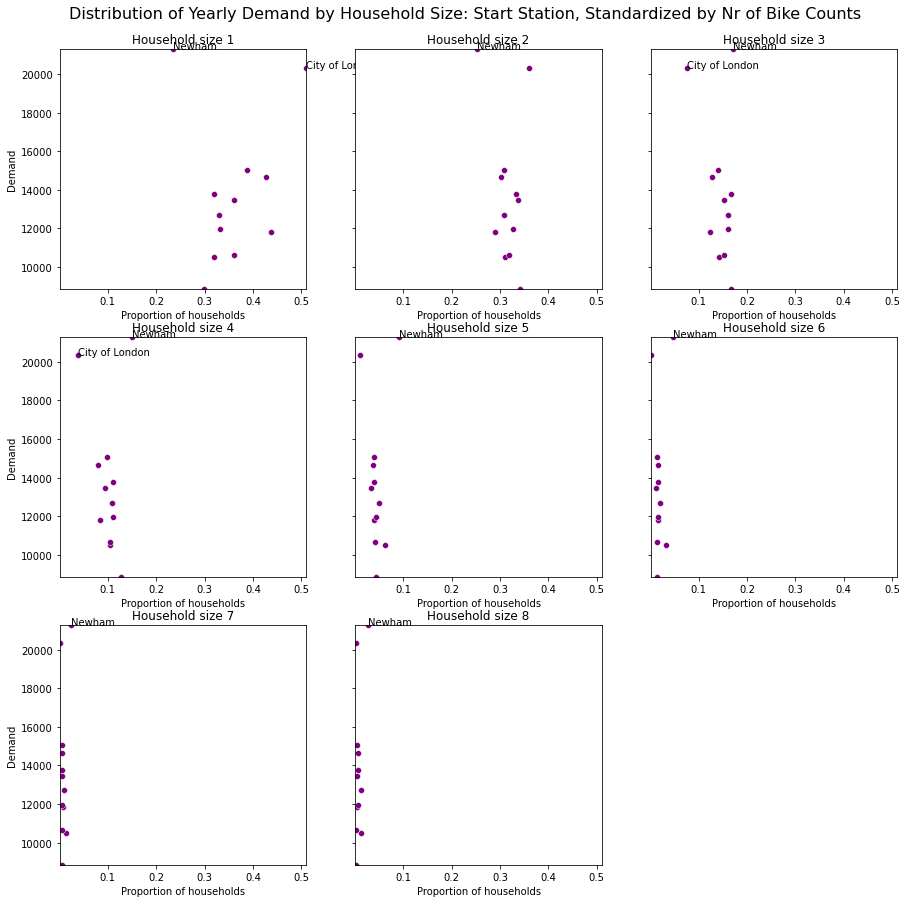

In [346]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Define a function to find outliers
def find_outliers(df, column1, column2):
    df = df.copy()  # Make a copy to avoid modifying original df
    df['Z_score1'] = zscore(df[column1])
    df['Z_score2'] = zscore(df[column2])
    outliers_df = df[(abs(df['Z_score1']) > 2) | (abs(df['Z_score2']) > 2)]
    return outliers_df

# Define max and min values for x and y axis
x_min = borough_df[[f'householdsize_{i}_ratio' for i in range(1, 9)]].min().min()
x_max = borough_df[[f'householdsize_{i}_ratio' for i in range(1, 9)]].max().max()
y_min = borough_df['demand_stand_count_2019_start_borough'].min()
y_max = borough_df['demand_stand_count_2019_start_borough'].max()

# Setup a grid of plots with 3 columns
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharey=True)

# Remove the last plot (we have 8 plots for household size 1-8, so the 9th plot is unnecessary)
fig.delaxes(axs[2,2])

# Iterate over each subplot
for i, ax in enumerate(fig.axes):
    if i < 8:
        col = f'householdsize_{i+1}_ratio'
        
        outliers_df = find_outliers(borough_df, col, 'demand_stand_count_2019_start_borough')
        
        sns.scatterplot(x=col, y='demand_stand_count_2019_start_borough', data=borough_df, ax=ax, color='purple') 
        
        for k in outliers_df.index:
            ax.annotate(outliers_df.loc[k, 'borough'], (outliers_df.loc[k, col], outliers_df.loc[k, 'demand_stand_count_2019_start_borough']))

        # Set title and labels
        ax.set_title(f'Household size {i+1}')
        ax.set_xlabel('Proportion of households')
        ax.set_ylabel('Demand')

        # Set x and y limits
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])

# Set main title
plt.suptitle('Distribution of Yearly Demand by Household Size: Start Station, Standardized by Nr of Bike Counts', fontsize=16, y=0.92)

plt.show()


In [355]:
from scipy import stats

# calculate correlation and p-value
correlation, p_value = stats.pearsonr(borough_df['population_density'], borough_df['demand_stand_count_2019_start_borough'])


In [356]:
print(correlation, p_value)

-0.5931141468851581 0.04207996592912195


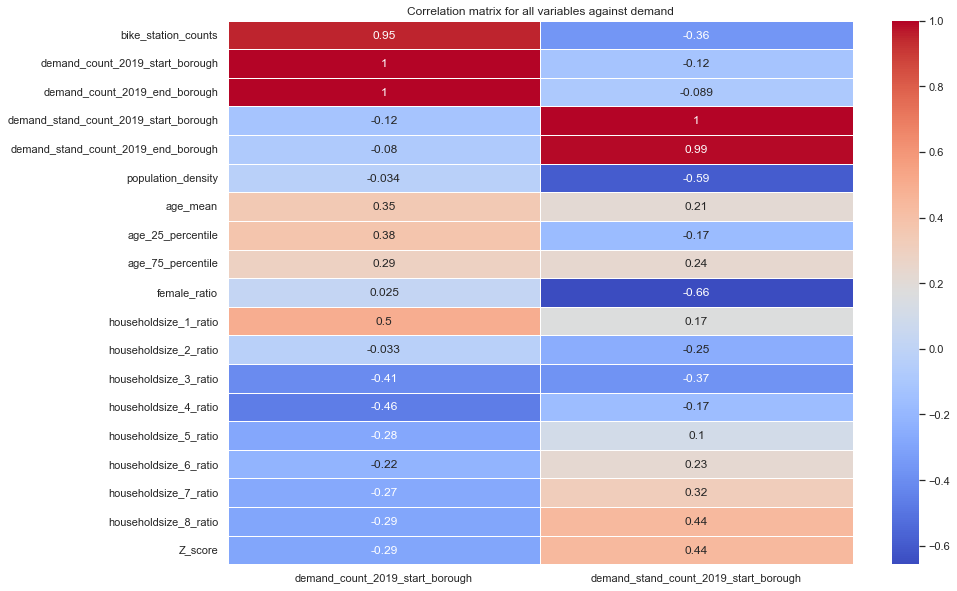

In [359]:
# calculate the correlation matrix
correlation_matrix = borough_df.corr()

# select rows of the correlation matrix
correlation_matrix_subset = correlation_matrix.loc[['demand_count_2019_start_borough', 'demand_stand_count_2019_start_borough'], :]

# transpose the subset of the correlation matrix
correlation_matrix_subset = correlation_matrix_subset.transpose()

# create the correlation plot
sns.set(style="white")
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_subset, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation matrix for all variables against demand")
plt.show()
